# **Project Name**    -  Integrated retail analytics



##### **Project Type**    - Regression
##### **Contribution**    - Individual
##### **Author**          - Aparna Praturi


# **Project Summary -**

# **GitHub Link -**

# **Problem Statement**


# **Part-I. Data Preparation and EDA**

## ***1. Knowing Data***

### 1.1. Importing Libraries

In [3]:
# Installling numpy version compatible with pmdarima

# !pip uninstall -y numpy
# !pip install numpy==1.26.4
# !pip install pmdarima

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import sys

In [6]:
!{sys.executable} -m pip install lightgbm optuna-integration[lightgbm]

In [7]:
# Import Libraries

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
import joblib
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from tqdm import tqdm
import optuna
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import TimeSeriesSplit



### 1.2 Loading Data

In [8]:
# Loading data

SCRIPT_DIR= Path().resolve().parent

cleaned_data_path = SCRIPT_DIR/'data'/'processed'/'cleaned_data.csv'

try:
  df_merged = pd.read_csv(f'{cleaned_data_path}')
  print(f"Data loaded into successfully!")

except FileNotFoundError:
    print(f"Error: The file(s)  were not found. Please check the path.")

Data loaded into successfully!


In [9]:
# 1️. SARIMA Objective Function (for Optuna tuning)
def seasonal_candidates_short_term(n_train_weeks: int):
    cands = [1, 4, 8, 13]  # 1 means "no seasonality"
    if n_train_weeks >= 2 * 26:   # only if >= ~1 year of history
        cands.append(26)
    return cands


def sarimax_objective_short(trial, y_train_tune, y_val_tune, exog_train_tune, exog_val_tune):
   
    n_train_weeks = len(y_train_tune)
    s = trial.suggest_categorical("s", seasonal_candidates_short_term(n_train_weeks))

    # Non-seasonal orders
    p = trial.suggest_int("p", 0, 2)
    d = trial.suggest_int("d", 0, 1)
    q = trial.suggest_int("q", 0, 2)

    # Seasonality switch
    if s == 1:
        P = D = Q = 0
    else:
        P = trial.suggest_int("P", 0, 1)
        if s >= 26:
            D = 0
        else:
            D = trial.suggest_int("D", 0, 1)
        Q = trial.suggest_int("Q", 0, 1)

    # Transform is fixed to log for stability
    transform = "log"

    try:
        # Prepare history and exog data for walk-forward loop
        history = np.log1p(y_train_tune)
        exog_history = exog_train_tune.copy()
        
        preds = []

        for t in range(len(y_val_tune)):
            # Define current training and future exog data for the next step
            current_exog_train = exog_history
            exog_future = exog_val_tune.iloc[[t]] 

            model = SARIMAX(
                history,
                exog=current_exog_train, 
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            fitted = model.fit(disp=False, maxiter=50)
            
            # Forecast 1 step with future exog data
            preds.append(fitted.forecast(steps=1, exog=exog_future)[0])

            # Update history for the next loop iteration
            new_obs = np.log1p(y_val_tune.iloc[t])
            history = pd.concat([history, pd.Series([new_obs], index=[y_val_tune.index[t]])])
            exog_history = pd.concat([exog_history, exog_val_tune.iloc[[t]]])

        # Inverse transform
        preds = np.expm1(preds)
        r2 = r2_score(y_val_tune, preds)
        return r2 
    except Exception:
        return -float("inf")

In [10]:
# SARIMAX  with Optuna

def fit_sarimax_short_term(store, df, exog_cols=None, horizon=8, n_trials=25):
   
   
    series = df['Weekly_Sales'].copy()
    
    X = df[exog_cols].copy()
    
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be DateTimeIndex.")
    series = series.asfreq("W-FRI").fillna(0).sort_index()
    X = X.reindex(series.index).fillna(0) # Align exog index to sales index

    if len(series) < 40:
        return None

    # 2. Data Splits (Train/Test)
    train_size = int(len(series) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    y_train, y_test_full = series.iloc[:train_size], series.iloc[train_size:]
    X_train, X_test_full = X.iloc[:train_size], X.iloc[train_size:]
    y_test = y_test_full.iloc[:horizon]
    X_test = X_test_full.iloc[:horizon]

    if len(y_train) < 12 or len(y_test) < 4:
        print(f" Store {store}: skipped SARIMAX/Hybrid - insufficient data (train={len(y_train)}, test={len(y_test)})")
        return None

    # 3. Inner Train/Val Split for Optuna Tuning
    split = int(len(y_train) * 0.8)
    y_train_tune, y_val_tune = y_train.iloc[:split], y_train.iloc[split:]
    X_train_tune, X_val_tune = X_train.iloc[:split], X_train.iloc[split:]


    # 4. Optuna Study
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda tr: sarimax_objective_short(
        tr, y_train_tune, y_val_tune, X_train_tune, X_val_tune),
        n_trials=n_trials, show_progress_bar=False)
    
    bp = study.best_params
    s = bp["s"]
    p, d, q = bp["p"], bp["d"], bp["q"]
    transform = "log" # Transform is fixed in the objective

    # 5. Get Seasonal Parameters (Robustly)
    P = 0 if s == 1 else bp.get("P", 0) 
    Q = 0 if s == 1 else bp.get("Q", 0) 
    D = 0 if s == 1 or s >= 26 else bp.get("D", 0)


    # 6. Final Fit on Full y_train (using X_train)
    transformed_train = np.log1p(y_train)
    final_model = SARIMAX(
        transformed_train,
        exog=X_train, # Pass X_train for final fit
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    sarima_fit = final_model.fit(disp=False, maxiter=50)

    # 7. Walk-forward test 
    history = transformed_train.copy()
    exog_history = X_train.copy()
    preds = []
    
    for t in range(len(y_test)):
        model = SARIMAX(
            history,
            exog=exog_history, # Current Exog data
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        fitted = model.fit(disp=False, maxiter=50)
        
        exog_future = X_test.iloc[[t]] # Future Exog for the next step
        preds.append(fitted.forecast(steps=1, exog=exog_future)[0])
        
        # Update history for the next iteration
        new_obs = np.log1p(y_test.iloc[t])
        history = pd.concat([history, pd.Series([new_obs], index=[y_test.index[t]])])
        exog_history = pd.concat([exog_history, X_test.iloc[[t]]])


    # Inverse transform and metrics
    preds = np.expm1(preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results = {
        "Store": store,
        "Model": "SARIMAX", # Changed name
        "Transform": transform,
        "RMSE": rmse,
        "R2": r2,
        "Best_Params": bp,
    }
    print(results)


        
    plt.figure(figsize=(12,6))
    plt.plot(train.index, y_train, label="Training Data", color="blue")
    plt.plot(y_test.index, y_test, label="Actual Test Data", color="green")
    plt.plot(y_test.index, preds, label="Prophet Forecast", color="red", linestyle="--")
    
    plt.title("Prophet Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.show()

In [11]:
# SARIMAX  with Optuna

def fit_sarimax_short_term(store, df, exog_cols=None, horizon=8, n_trials=25):
    RESULTS_DIR = SCRIPT_DIR/'results' 
    RESULTS_DIR.mkdir(parents=True, exist_ok=True) 
   
    series = df['Weekly_Sales'].copy()
    
    X = df[exog_cols].copy()
    
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be DateTimeIndex.")
    series = series.asfreq("W-FRI").fillna(0).sort_index()
    X = X.reindex(series.index).fillna(0) # Align exog index to sales index

    if len(series) < 40:
        return None

    # 2. Data Splits (Train/Test)
    train_size = int(len(series) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    y_train, y_test_full = series.iloc[:train_size], series.iloc[train_size:]
    X_train, X_test_full = X.iloc[:train_size], X.iloc[train_size:]
    y_test = y_test_full.iloc[:horizon]
    X_test = X_test_full.iloc[:horizon]

    if len(y_train) < 12 or len(y_test) < 4:
        print(f" Store {store}: skipped SARIMAX/Hybrid - insufficient data (train={len(y_train)}, test={len(y_test)})")
        return None

    # 3. Inner Train/Val Split for Optuna Tuning
    split = int(len(y_train) * 0.8)
    y_train_tune, y_val_tune = y_train.iloc[:split], y_train.iloc[split:]
    X_train_tune, X_val_tune = X_train.iloc[:split], X_train.iloc[split:]


    # 4. Optuna Study
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda tr: sarimax_objective_short(
        tr, y_train_tune, y_val_tune, X_train_tune, X_val_tune),
        n_trials=n_trials, show_progress_bar=False)
    
    bp = study.best_params
    s = bp["s"]
    p, d, q = bp["p"], bp["d"], bp["q"]
    transform = "log" # Transform is fixed in the objective

    # 5. Get Seasonal Parameters (Robustly)
    P = 0 if s == 1 else bp.get("P", 0) 
    Q = 0 if s == 1 else bp.get("Q", 0) 
    D = 0 if s == 1 or s >= 26 else bp.get("D", 0)


    # 6. Final Fit on Full y_train (using X_train)
    transformed_train = np.log1p(y_train)
    final_model = SARIMAX(
        transformed_train,
        exog=X_train, # Pass X_train for final fit
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    sarima_fit = final_model.fit(disp=False, maxiter=50)

    # 7. Walk-forward test 
    history = transformed_train.copy()
    exog_history = X_train.copy()
    preds = []
    
    for t in range(len(y_test)):
        model = SARIMAX(
            history,
            exog=exog_history, # Current Exog data
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        fitted = model.fit(disp=False, maxiter=50)
        
        exog_future = X_test.iloc[[t]] # Future Exog for the next step
        preds.append(fitted.forecast(steps=1, exog=exog_future)[0])
        
        # Update history for the next iteration
        new_obs = np.log1p(y_test.iloc[t])
        history = pd.concat([history, pd.Series([new_obs], index=[y_test.index[t]])])
        exog_history = pd.concat([exog_history, X_test.iloc[[t]]])


    # Inverse transform and metrics
    preds = np.expm1(preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results = {
        "Store": store,
        "Model": "SARIMAX", # Changed name
        "Transform": transform,
        "RMSE": rmse,
        "R2": r2,
        "Best_Params": bp,
    }
    print(results)


        
    plt.figure(figsize=(12,6))
    plt.plot(train.index, y_train, label="Training Data", color="blue")
    plt.plot(y_test.index, y_test, label="Actual Test Data", color="green")
    plt.plot(y_test.index, preds, label="Sarimax Forecast", color="red", linestyle="--")
    
    plt.title("short term SARIMAX Forecast vs Actuals for store 10")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    PLOT_FILENAME = f'shortterm forecasting using sarimax for store {store}.png'
    PLOT_SAVE_PATH = RESULTS_DIR / PLOT_FILENAME 
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Plot saved successfully to: {PLOT_SAVE_PATH}")
    plt.legend()
    plt.show()

[I 2025-10-10 12:06:52,198] A new study created in memory with name: no-name-25099eee-cda7-42e0-8b89-9afe62cc03db
[I 2025-10-10 12:06:52,207] Trial 0 finished with value: -inf and parameters: {'s': 1, 'p': 0, 'd': 1, 'q': 0}. Best is trial 0 with value: -inf.
[I 2025-10-10 12:06:52,209] Trial 1 finished with value: -inf and parameters: {'s': 1, 'p': 0, 'd': 0, 'q': 1}. Best is trial 0 with value: -inf.
[I 2025-10-10 12:06:52,211] Trial 2 finished with value: -inf and parameters: {'s': 1, 'p': 2, 'd': 0, 'q': 2}. Best is trial 0 with value: -inf.
c:\Users\aparn\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\aparn\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

{'Store': 10, 'Model': 'SARIMAX', 'Transform': 'log', 'RMSE': 93519.51382217846, 'R2': -0.727071024078767, 'Best_Params': {'s': 4, 'p': 1, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 0}}
Plot saved successfully to: C:\Users\aparn\OneDrive\Desktop\AB\Advanced ML\Retail Analytics\results\shortterm forecasting using sarimax for store 10.png


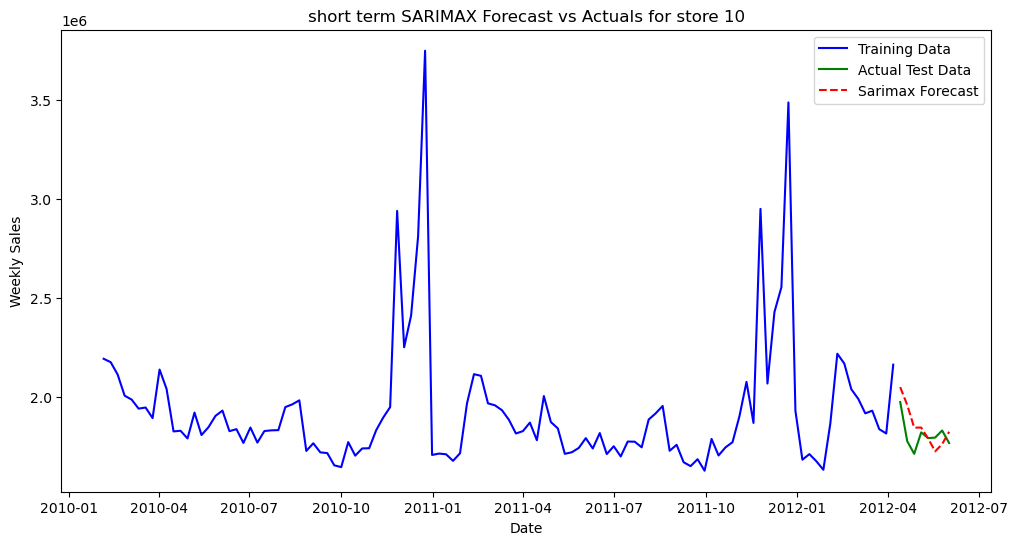

In [12]:
store=10
exog_cols= ['IsHoliday', 'Total_MarkDown']


df = df_merged[['Store','Date','Weekly_Sales'] + exog_cols].copy()

# for stor in df_forecast['Store'].unique():
#     prophet_forecast_tuned(df_forecast, horizon=horizon_long, level="Store", store=stor)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
agg = df[df['Store'] == store].drop(columns=['Store'])

agg_map = {'Weekly_Sales': 'sum'}

valid_exog_cols = [c for c in exog_cols if c in agg.columns]
agg_map.update({c: 'mean' for c in valid_exog_cols})
df_store = agg.resample('W-FRI').agg(agg_map).fillna(0)
        
fit_sarimax_short_term(store, df_store, exog_cols=exog_cols, horizon=8, n_trials=25)

### LightGBM for short term forecasting

In [13]:
def make_lags(df, nlags = [4,8, 13], nrolling=[4,8, 13]):
    if 'y' not in df.columns:
        raise ValueError("DataFrame must contain a 'y' column for lag creation.")
    df = df.copy()
    for lag in  nlags:
        df[f'lag_{lag}'] = df['y'].shift(lag)
    for window in nrolling:
        df[f'rolling_mean_{window}'] = df['y'].rolling(window=window).mean().shift(1)
            
        # Rolling Standard Deviation 
        df[f'rolling_std_{window}'] = df['y'].rolling(window=window).std().shift(1)
        
    return df

In [14]:
def create_features(df: pd.DataFrame):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DateTimeIndex.")
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    df['dayofweek'] = df.index.dayofweek
    # df['quarter'] = df.index.quarter
    # df['is_month_start'] = df.index.is_month_start.astype(int)
    # df['is_month_end'] = df.index.is_month_end.astype(int)
    # df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    # df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_year_start'] = df.index.is_year_start.astype(int)
    df['is_year_end'] = df.index.is_year_end.astype(int)
    df['time_idx'] = (df.index - df.index.min()).days
    return df

In [15]:
def lgbm_objective(trial, X_res, y_res, n_splits=5):

    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        'verbose': -1, # Suppress output
        'n_jobs': -1,
        'seed': 42 # Ensure reproducibility
    }

    #  Time Series Cross-Validation
   
    tscv = TimeSeriesSplit(n_splits=n_splits)
    def rolling_folds_index(n, val_size=8, min_train=40, step=8):
     # yields (train_idx, val_idx) for rolling-origin CV
        start = min_train
        while start + val_size <= n:
            train_idx = np.arange(0, start)
            val_idx   = np.arange(start, start + val_size)
            yield train_idx, val_idx
            start += step
        
    r2_list = []
    rmse_list=[]
    n = len(X_res)  
    
    for train_index, val_index in rolling_folds_index(n, val_size=8, min_train=40, step=8):
        X_train, X_val = X_res.iloc[train_index], X_res.iloc[val_index]
        y_train, y_val = y_res.iloc[train_index], y_res.iloc[val_index]
        
        # Check for sufficient data
        if len(y_val) == 0:
            continue

        try:
            model = LGBMRegressor(**param)
            model.fit(X_train, y_train, 
                      eval_set=[(X_val, y_val)],
                    #   early_stopping_rounds=50, # Early stop to prevent overfitting
                      eval_metric='rmse',
                      callbacks=[optuna.integration.LightGBMPruningCallback(trial, 'rmse')]
                      )
            
            preds = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, preds))
            r2 = r2_score(y_val, preds)
            r2_list.append(rmse)
            rmse_list.append(rmse)
        
        except Exception as e:
            print(f" Trial failed: {e}")
          
            return -float("inf") 

   
    return np.mean(rmse_list) if r2_list else -float("inf")

In [16]:
def fit_lgbm_direct_short_term(store, df, exog_cols=None, horizon=8, n_trials=35):

    RESULTS_DIR = SCRIPT_DIR/'results' 
    RESULTS_DIR.mkdir(parents=True, exist_ok=True) 

    df = df.copy().sort_index()
    series = df['Weekly_Sales'].copy()
    
    #  Prepare Data and Features
    series_df = pd.DataFrame({'y': series})
    
    # Add calendar features
    X_feats = create_features(series_df) 
    
    # Add lagged sales features
    X_feats = make_lags(X_feats, nlags = [1,2,4,8], nrolling=[4,8])
    
    # Add exogenous features
    if exog_cols:
        X_exog = df[exog_cols].copy()
        X_feats = X_feats.join(X_exog, how='left')

    # Drop rows with NaN 
    X_feats = X_feats.dropna()
    y = X_feats['y'].copy()
    X = X_feats.drop(columns=['y'])

    #  Data Splits
    train_size = int(len(y) * 0.8)
    train,test = df.iloc[:train_size], df.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

    if len(y_train) < 10 or len(y_test) < 4:
        print(f" Store {store}: skipped Direct LGBM - insufficient data.")
        return None

    #  Optuna Study 
    study = optuna.create_study(direction="minimize", study_name=f"lgbm_tune_direct_store_{store}")
    study.optimize(lambda trial: lgbm_objective(trial, X_train, y_train), 
                   n_trials=n_trials, show_progress_bar=False)
    
    bp = study.best_params
    bp.update({'objective': 'regression', 'n_jobs': -1, 'seed': 42, 'verbose': -1})

    # Final Fit on Full Training Data
    lgbm_fit = LGBMRegressor(**bp)
    lgbm_fit.fit(X_train, y_train)

    # Prediction on Test Set (Non-recursive prediction, simple model forecast)
    preds = lgbm_fit.predict(X_test)

    #  Metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results = {
        "Store": store,
        "Model": "LGBM_Direct",
        "Transform": "none",
        "RMSE": rmse,
        "R2": r2,
        "Best_Params": bp,
        "Trained_Model": lgbm_fit
    }
    print(results)

    # Plotting 
    plt.figure(figsize=(12,6))
    plt.plot(train.index, y_train, label="Training Data", color="blue")
    plt.plot(y_test.index, y_test, label="Actual Test Data", color="green")
    plt.plot(y_test.index, preds, label="Prophet Forecast", color="red", linestyle="--")
    
    plt.title("Short term lgbm Forecast vs Actuals for store 10")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.legend()
    PLOT_FILENAME = f'shortterm forecasting using LightGBM for store {store}.png'
    PLOT_SAVE_PATH = RESULTS_DIR / PLOT_FILENAME 
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Plot saved successfully to: {PLOT_SAVE_PATH}")
    plt.show()

[I 2025-10-10 12:08:32,489] A new study created in memory with name: lgbm_tune_direct_store_10


[I 2025-10-10 12:08:32,801] Trial 0 finished with value: 230943.76085433533 and parameters: {'n_estimators': 168, 'learning_rate': 0.02348346575444548, 'feature_fraction': 0.7468982229741792, 'bagging_fraction': 0.529497611324778, 'bagging_freq': 1, 'lambda_l1': 1.4764772574273061e-05, 'lambda_l2': 0.9750110819743301, 'num_leaves': 24}. Best is trial 0 with value: 230943.76085433533.
[I 2025-10-10 12:08:33,070] Trial 1 finished with value: 214095.4075435323 and parameters: {'n_estimators': 244, 'learning_rate': 0.02575467582604594, 'feature_fraction': 0.8896074857466049, 'bagging_fraction': 0.6982099716703196, 'bagging_freq': 6, 'lambda_l1': 2.509597889265145e-07, 'lambda_l2': 3.965794953895751, 'num_leaves': 12}. Best is trial 1 with value: 214095.4075435323.
[I 2025-10-10 12:08:33,274] Trial 2 finished with value: 227997.9277627081 and parameters: {'n_estimators': 184, 'learning_rate': 0.0441605305160631, 'feature_fraction': 0.9574838669191532, 'bagging_fraction': 0.7756888304028622,

{'Store': 10, 'Model': 'LGBM_Direct', 'Transform': 'none', 'RMSE': 88389.35888345666, 'R2': -0.5648222470876312, 'Best_Params': {'n_estimators': 237, 'learning_rate': 0.027719543296121616, 'feature_fraction': 0.9097523953641901, 'bagging_fraction': 0.6407034524482541, 'bagging_freq': 6, 'lambda_l1': 1.4312914035217892e-07, 'lambda_l2': 3.016317942742167e-07, 'num_leaves': 34, 'objective': 'regression', 'n_jobs': -1, 'seed': 42, 'verbose': -1}, 'Trained_Model': LGBMRegressor(bagging_fraction=0.6407034524482541, bagging_freq=6,
              feature_fraction=0.9097523953641901,
              lambda_l1=1.4312914035217892e-07, lambda_l2=3.016317942742167e-07,
              learning_rate=0.027719543296121616, n_estimators=237, n_jobs=-1,
              num_leaves=34, objective='regression', seed=42, verbose=-1)}
Plot saved successfully to: C:\Users\aparn\OneDrive\Desktop\AB\Advanced ML\Retail Analytics\results\shortterm forecasting using LightGBM for store 10.png


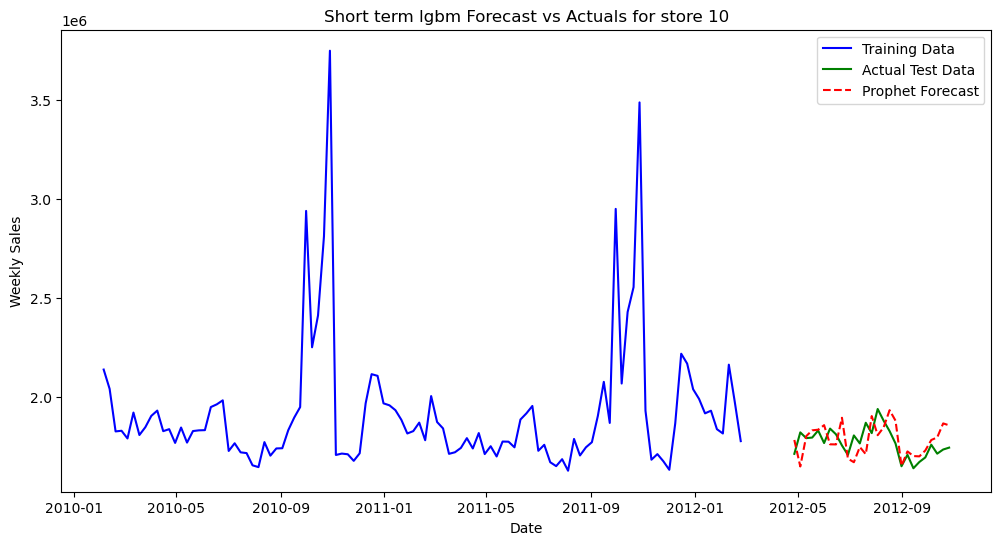

In [17]:
store=10

exog_cols= ['IsHoliday', 'Total_MarkDown']
df = df_merged[['Store','Date','Weekly_Sales'] + exog_cols].copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
agg = df[df['Store'] == store].drop(columns=['Store'])
agg_map = {'Weekly_Sales': 'sum'}
valid_exog_cols = [c for c in exog_cols if c in agg.columns]
agg_map.update({c: 'mean' for c in valid_exog_cols})
df_store = agg.resample('W-FRI').agg(agg_map).fillna(0)
# for stor in df_forecast['Store'].unique():
fit_lgbm_direct_short_term(store, df_store, exog_cols=exog_cols, horizon=8, n_trials=30)